In [1]:
# coding=utf-8

import os
import pandas as pd
import numpy as np
import nltk
from collections import Counter
from gensim import corpora
from gensim import models

ROOTDIR = os.path.abspath(os.path.abspath(os.path.join(os.getcwd(), "..")))
DATADIR = os.path.join(ROOTDIR, 'data')
MODELDIR = os.path.join(ROOTDIR, 'model')

dictionary_zh = corpora.Dictionary.load(MODELDIR + '/question_zh.dict')
w2v_model_zh = models.Word2Vec.load(MODELDIR + "/word2vec_zh.model")
dictionary_en = corpora.Dictionary.load(MODELDIR + '/question.dict')
w2v_model_en = models.Word2Vec.load(MODELDIR + "/word2vec.model")
df = pd.read_csv(os.path.join(DATADIR, 'question.csv'), nrows=100000)

In [2]:
import jieba

texts_zh= df.translatedContent
texts_en= df.content

tokenized_en = [nltk.word_tokenize(question) for question in texts_en]

frequent_tokenized_en = []
for sentence in tokenized_en:
    ind_list = dictionary_en.doc2idx(sentence)
    words = []
    for i,ind in enumerate(ind_list):
        if ind != -1:
            words.append(sentence[i])
    frequent_tokenized_en.append(words)

tokenized_zh = [list(jieba.cut(question, HMM=False)) for question in texts_zh]

frequent_tokenized_zh = []
for sentence in tokenized_zh:
    ind_list = dictionary_zh.doc2idx(sentence)
    words = []
    for i,ind in enumerate(ind_list):
        if ind != -1:
            words.append(sentence[i])
    frequent_tokenized_zh.append(words)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\frank\AppData\Local\Temp\jieba.cache
Loading model cost 0.487 seconds.
Prefix dict has been built successfully.


In [3]:
from nltk.corpus import stopwords
from string import punctuation
from itertools import chain
from tqdm import tqdm

def clean_text(tokenized_list, sw, punct):
    new_list = []
    for doc in tqdm(tokenized_list):
        new_list.append([token.lower() for token in doc if token.lower() not in chain(punct, sw)])
    return new_list

sw_en = stopwords.words('english')
punct_en = ' \n'+'!"#%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
punct_zh =  '《》，。？/：；‘’“”{}【】、|—·！~ \n'+'!"#%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
sw_zh = []
with open (DATADIR + "/cn_stopwords.txt", 'r', encoding='utf8') as f:
    sw_zh = f.read().split('\n')
    
cleaned_zh = clean_text(frequent_tokenized_zh, sw_zh, punct_zh)
cleaned_en = clean_text(frequent_tokenized_en, sw_en, punct_en)

100%|████████████████████████████████████████████████████████████████████████████| 1157/1157 [00:00<00:00, 2222.41it/s]


In [4]:
vec_zh = np.array([w2v_model_zh.wv[q].sum(axis=0)/len(q) for q in cleaned_zh])
vec_en = np.array([w2v_model_en.wv[q].sum(axis=0)/len(q) for q in cleaned_en])

del cleaned_zh
del cleaned_en

In [5]:
likes = np.array(df.likes)

likes

array([8576, 4544, 3918, ...,    8,   18,    9], dtype=int64)

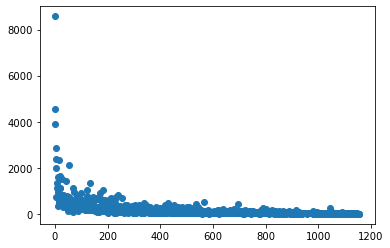

In [6]:
#点赞数 长尾分布
#点赞数/提交数 均匀分布
%matplotlib inline

import matplotlib 
import matplotlib.pyplot as plt

x = np.array(range(len(likes)))
y = likes
plt.scatter(x, y)
plt.show()

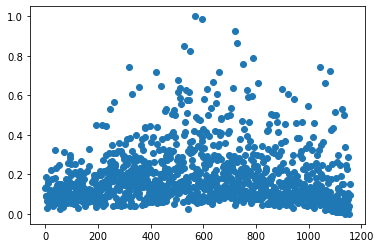

In [7]:
totalSubmission = np.array(df.totalSubmission)

corrected_likes = likes/totalSubmission
corrected_likes = corrected_likes/corrected_likes.max()

x = np.array(range(len(likes)))
y = corrected_likes
plt.scatter(x, y)
plt.show()

In [23]:
from sklearn.model_selection import train_test_split

seed = 42
test_size = 0.33

X = vec_zh
y = corrected_likes

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

### ridge regression

In [24]:
#线性模型
from sklearn import linear_model

linear_reg = linear_model.Ridge(alpha=0.5)
linear_reg = linear_reg.fit(X_train, y_train)

y_pred = linear_reg.predict(X_test)

# check the accuracy on the training set
linear_reg.score(X_test, y_test)

-0.019352070937959542

### svm regression
#svm回归

In [25]:
from sklearn import svm

svm_reg = svm.SVR()
svm_reg = svm_reg.fit(X_train, y_train)

y_pred = svm_reg.predict(X_test)

# check the accuracy on the training set
svm_reg.score(X_test, y_test)

0.09467015038209403

### svm regression with standardization

In [11]:
def standardization(data):
    mu = np.mean(data, axis=0)
    sigma = np.std(data, axis=0)
    return (data - mu) / sigma

X = standardization(vec_zh)
X = np.insert(X, 0, 1, axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

svm_reg = svm.SVR()
svm_reg = svm_reg.fit(X_train, y_train)

y_pred = svm_reg.predict(X_test)

# check the accuracy on the training set
svm_reg.score(X_test, y_test)

0.07029518810810365

### Voting Regressor

In [12]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import VotingRegressor

reg1 = GradientBoostingRegressor(random_state=1, n_estimators=10)
reg2 = RandomForestRegressor(random_state=1, n_estimators=10)
reg3 = LinearRegression()

vot_reg = VotingRegressor(estimators=[('gb', reg1), ('rf', reg2), ('lr', reg3)])
vot_reg = vot_reg.fit(X_train, y_train)

y_pred = vot_reg.predict(X_test)

# check the accuracy on the training set
vot_reg.score(X_test, y_test)

0.016424946061624923

### NN Regressor with sigmoid
#神经网络

In [13]:
import torch
from torch import nn, optim

class NN_reg(torch.nn.Module):
    def __init__(self,feature_num):
        super(NN_reg, self).__init__()
        self.l = torch.nn.Linear(feature_num, 1)
        self.s = nn.Sigmoid()

    def forward(self, x):
        x = self.l(x)
        x = self.s(x)
        return x
    
X = torch.tensor(vec_zh).float()
y = torch.tensor(corrected_likes)
y = torch.reshape(y,(-1,1)).float()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

net = NN_reg(X.shape[1])
print(net)

NN_reg(
  (l): Linear(in_features=300, out_features=1, bias=True)
  (s): Sigmoid()
)


In [14]:
loss_func = torch.nn.MSELoss() 
optimizer = optim.SGD(net.parameters(), lr=0.005, momentum=0.9)
#训练
for t in range(2000):
    prediction = net(X_train)
    loss = loss_func(prediction, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [15]:
#测试
from sklearn.metrics import r2_score
prediction = net(X_test)
r2_score(y_test,prediction.data.numpy())

0.08285465055005126

### NN Regressor without sigmoid

In [153]:
HIDDEN = 10

class NN_reg(torch.nn.Module):
    def __init__(self,feature_num):
        super(NN_reg, self).__init__()
        self.l = torch.nn.Linear(feature_num, HIDDEN)
        self.out = torch.nn.Linear(HIDDEN, 1)

    def forward(self, x):
        x = self.l(x)
        x = self.out(x)
        return x
    
X = torch.tensor(vec_zh).float()
y = torch.tensor(corrected_likes)
y = torch.reshape(y,(-1,1)).float()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

net = NN_reg(X.shape[1])
print(net)

NN_reg(
  (l): Linear(in_features=300, out_features=10, bias=True)
  (out): Linear(in_features=10, out_features=1, bias=True)
)


In [154]:
loss_func = torch.nn.MSELoss() 
optimizer = optim.SGD(net.parameters(), lr=0.005, momentum=0.9)

loss_min = 1
for t in range(3000):
    prediction = net(X_train)
    loss = loss_func(prediction, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if t%100 == 0:
        print(t,loss.data.numpy())

0 0.024358548
100 0.017748618
200 0.016625583
300 0.01601156
400 0.015590989
500 0.015269746
600 0.015007348
700 0.0147832455
800 0.014585944
900 0.014408559
1000 0.014246768
1100 0.014097719
1200 0.013959463
1300 0.013830598
1400 0.013710075
1500 0.01359706
1600 0.013490865
1700 0.013390905
1800 0.013296664
1900 0.013207669
2000 0.013123494
2100 0.013043741
2200 0.012968043
2300 0.012896066
2400 0.012827494
2500 0.0127620455
2600 0.012699464
2700 0.012639509
2800 0.01258197
2900 0.012526654


In [155]:
from sklearn.metrics import r2_score
prediction = net(X_test)
r2_score(y_test,prediction.data.numpy())

0.022133680002894063

# 题目难度分析

In [16]:
texts = df.translatedContent

In [17]:
import jieba
from nltk.corpus import stopwords
from string import punctuation
from itertools import chain
from tqdm import tqdm

dictionary = corpora.Dictionary.load(MODELDIR + '/question_zh.dict')
tokenized = [list(jieba.cut(question, HMM=False)) for question in texts]

frequent_tokenized = []
for sentence in tokenized:
    ind_list = dictionary.doc2idx(sentence)
    words = []
    for i,ind in enumerate(ind_list):
        if ind != -1:
            words.append(sentence[i])
    frequent_tokenized.append(words)
    


def clean_text(tokenized_list, sw, punct):
    new_list = []
    for doc in tqdm(tokenized_list):
        new_list.append([token.lower() for token in doc if token.lower() not in chain(punct, sw)])
    return new_list

punct =  '《》，。？/：；‘’“”{}【】、|—·！~ \n'+'!"#%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
sw = []
with open (DATADIR + "/cn_stopwords.txt", 'r', encoding='utf8') as f:
    sw = f.read().split('\n')
    
cleaned = clean_text(frequent_tokenized, sw, punct)

100%|█████████████████████████████████████████████████████████████████████████████| 1157/1157 [00:02<00:00, 573.44it/s]


In [21]:
vec = np.array([w2v_model_zh.wv[q].sum(axis=0)/len(q) for q in cleaned])

vec.shape

(1157, 300)

In [34]:
popularity = linear_reg.predict(vec)

popularity

array([0.03540647, 0.13903075, 0.04521823, ..., 0.12312686, 0.1770728 ,
       0.19676012], dtype=float32)

In [36]:
print(min(popularity))
print(max(popularity))

0.1353221
0.8000923


In [35]:
popularity = popularity + 0.3

In [40]:
result_df = pd.read_csv(os.path.join(DATADIR, 'leetcode_result.csv'), nrows=100000)

result_df

,questionId,lite_score,sch_score,d2_score,oral_score,diffculty,popularity
0,1,0.200000,0.900000,0.500000,0.200000,0.559645,0.335406
1,2,0.142857,0.857143,0.571429,0.142857,0.449437,0.439031
2,3,0.208333,0.875000,0.541667,0.100000,0.408112,0.345218
3,4,0.500000,0.750000,0.250000,0.125000,0.532104,0.660025
4,5,0.111111,0.777778,0.666667,0.333333,0.467431,0.374785
...,...,...,...,...,...,...,...
1152,1622,0.161290,0.677419,0.129032,0.419355,0.498648,0.441616
1153,1626,0.142857,0.785714,0.428571,0.100000,0.657149,0.414235
1154,1627,0.183673,0.530612,0.448980,0.142857,0.452381,0.423127
1155,1628,0.200000,0.500000,0.400000,0.100000,0.525563,0.477073


In [38]:
result_df['popularity'] = popularity

result_df

,questionId,lite_score,sch_score,d2_score,oral_score,diffculty,popularity
0,1,0.200000,0.900000,0.500000,0.200000,0.559645,0.335406
1,2,0.142857,0.857143,0.571429,0.142857,0.449437,0.439031
2,3,0.208333,0.875000,0.541667,0.100000,0.408112,0.345218
3,4,0.500000,0.750000,0.250000,0.125000,0.532104,0.660025
4,5,0.111111,0.777778,0.666667,0.333333,0.467431,0.374785
...,...,...,...,...,...,...,...
1152,1622,0.161290,0.677419,0.129032,0.419355,0.498648,0.441616
1153,1626,0.142857,0.785714,0.428571,0.100000,0.657149,0.414234
1154,1627,0.183673,0.530612,0.448980,0.142857,0.452381,0.423127
1155,1628,0.200000,0.500000,0.400000,0.100000,0.525563,0.477073


In [39]:
result_df.to_csv(os.path.join(DATADIR, 'leetcode_result.csv'),index=0)